In [ ]:
#|default_exp data

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export() # C-s and C-RET to save and export

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

# Data
> Data generation, preprocessing, and loading.

In [ ]:
#|export
from fastai.vision.all import *
import andi_datasets
from tqdm.auto import tqdm, trange
from scipy.special import erfcinv

In [ ]:
#|hide
from SPIVAE.utils import D2sig, sig2D

# Data generation

To study stochastic processes, we take trajectories from three paradigmatic diffusion models: Brownian motion, fractional Brownian motion, and scaled Brownian motion.

We generate the trajectories with the [andi_datasets](https://doi.org/10.5281/zenodo.4775311) package.

In [ ]:
#|export
from andi_datasets.datasets_theory import datasets_theory
AD = datasets_theory()

## Fractional Brownian motion

For fractional Brownian motion (FBM), we take $\alpha\in[0.04, 1.96]$.
For the dataset of Brownian motion (BM), we can take directly the FBM trajectories with $\alpha=1$.

In [ ]:
alphas_train = np.linspace(0.2,1.8,21)
alphas_test = np.linspace(0.04,1.96,49)
print(f'{alphas_train=}')
print(f'{alphas_test=}')

alphas_train=array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ,
       1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ])
alphas_test=array([0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44,
       0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88,
       0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32,
       1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76,
       1.8 , 1.84, 1.88, 1.92, 1.96])


As advised in the [andi_datasets](https://doi.org/10.5281/zenodo.4775311) library, we can save at the beginning a big dataset (`t_save` $\sim 10^3$ and `N_save` $\sim 10^4$) which then allows us to load any other combination of `T` and `N_models`.

In [ ]:
AD.avail_models_name

['attm', 'ctrw', 'fbm', 'lw', 'sbm']

In [ ]:
T=400 ;  N=6_000
dataset = AD.create_dataset(T=T, N_models=N,
                            exponents=alphas_test,
                            models=[2],   # fbm
                            dimension=1,
                            N_save=N,
                            t_save=T,
                            save_trajectories=True,
                            load_trajectories=False, # False allows saving 
                            path="../../data/raw/")

The [andi_datasets](https://doi.org/10.5281/zenodo.4775311) gives us the trajectories with shape $[N*|\mathrm{exponents}|, 2+T]$ where the first two data points of each vector are the model label and the anomalous exponent $\alpha$.

In [ ]:
dataset.shape, dataset[0,:2], dataset[-1,:2]

((294000, 402), array([2.  , 0.04]), array([2.  , 1.96]))

The following $T$ points compose the trajectory that always has zero origin. 

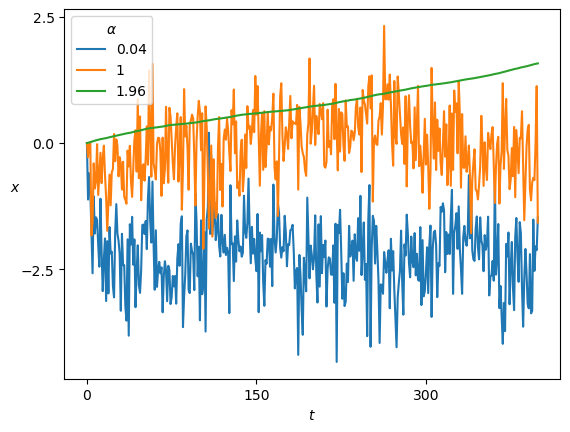

In [ ]:
plt.plot(dataset[0,2:], label=f'{alphas_test[0]:.3g}');
plt.plot(dataset[49//2,2:], label=f'{alphas_test[49//2]:.3g}');
plt.plot(dataset[-1,2:], label=f'{alphas_test[-1]:.3g}');
plt.xlabel(r'$t$');plt.ylabel(r'$x$', rotation=0);
plt.legend(title=r'$\alpha$');

The distribution of the positions $x(t)$ depends on $\alpha$ and time, as we expect from the mean squared displacement relation $\langle x^2\rangle=2 D t^\alpha$.

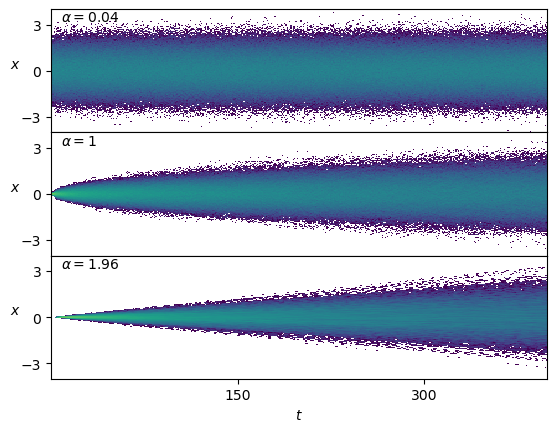

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
for ax, a_i in zip(axs,[0,49//2,48]):
    ax.hist2d(np.tile(np.arange(T),N),dataset[a_i*N:(a_i+1)*N,2:].reshape(-1), T, cmin=2, norm=matplotlib.colors.LogNorm());
    ax.text(0.02,0.9, r'$\alpha=' f'{dataset[a_i*N,1]:.3g}' r'$', transform=ax.transAxes);
    ax.set_ylabel(r'$x$', rotation=0);
    ax.set_ylim([-4,4])
axs[-1].set_xlabel(r'$t$');

Conveniently, the displacements $\Delta x$ are stationary.

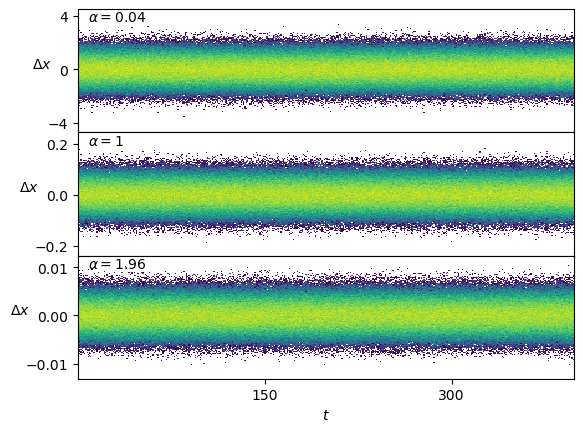

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
for ax, a_i in zip(axs,[0,49//2,48]):
    ax.hist2d(np.tile(np.arange(T-1),N),np.subtract(dataset[a_i*N:(a_i+1)*N,3:],dataset[a_i*N:(a_i+1)*N,2:-1]).reshape(-1), T-1, cmin=2, norm=matplotlib.colors.LogNorm());
    ax.text(0.02,0.9, r'$\alpha=' f'{dataset[a_i*N,1]:.3g}' r'$', transform=ax.transAxes);
axs[-1].set_xlabel(r'$t$');
for ax in axs : ax.set_ylabel(r'$\Delta x$', rotation=0);

## Scaled Brownian motion

For the generation of scaled Brownian motion (SBM) trajectories, we take the generating function from
[andi_datasets](https://github.com/AnDiChallenge/andi_datasets/blob/develop/source_nbs/lib_nbs/models_theory.ipynb)
to control sigma as $D_0$ and generate displacements directly.

In [ ]:
#|export
def sbm(T, alpha, sigma = 1):
    '''Creates `T` scaled Brownian motion displacements'''
    msd = (sigma**2)*np.arange(T+1)**alpha
    dx = np.sqrt(msd[1:]-msd[:-1])
    dx = np.sqrt(2)*dx*erfcinv(2-2*np.random.rand(len(dx)))
    return dx
    # return np.cumsum(dx)-dx[0]  # trajectory centered at origin

We select the range of values to coincide with the previous dataset.

In [ ]:
T=400; N=1_000
Ds = np.geomspace(1e-5,1e-2, 10)
alphas_train = np.linspace(0.2,1.8,21)

In [ ]:
disp = {f'{a:.3g}'+f',{D:.3g}':[] for D in Ds for a in alphas_train}
fname = '../../data/raw/sbm.npz'
if not os.path.exists(fname):  # create
    for i,a in enumerate(alphas_train):
        for j,D in enumerate(Ds):
            k = f'{a:.3g}'+f',{D:.3g}'
            disp[k]=np.array([np.concatenate(([a,D],sbm(T, a, sigma = D2sig(D)))) for n in range(N)]) # N, T+2
    np.savez_compressed(fname,**disp)
    print('Saved at:', fname)
else:  # load
    with np.load(fname) as f:
        for i,a in enumerate(alphas_train):
            for j,D in enumerate(Ds):
                k = f'{a:.3g}'+f',{D:.3g}'
                disp[k] = f[k][:N,:2+T]
    print('Loaded from:', fname)

Loaded from: ../../data/raw/sbm.npz


The displacements follow the temporal scaling $D_\alpha(t) = \alpha D_0 t^{\alpha-1}$.

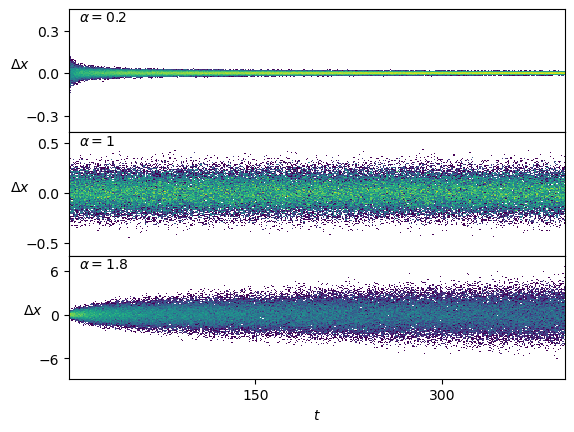

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
for ax, a in zip(axs,[0.2,1,1.8]):
    k = f'{a:.3g}'+f',0.01'
    ax.hist2d(np.tile(np.arange(T),N),disp[k][:,2:].reshape(-1), T, cmin=2, norm=matplotlib.colors.LogNorm());
    ax.text(0.02,0.9, r'$\alpha=' f'{a:.3g}' r'$', transform=ax.transAxes);
    ax.set_ylabel(r'$\Delta x$', rotation=0);
axs[-1].set_xlabel(r'$t$');

We can do the same to create a test set.

In [ ]:
Ds = np.geomspace(1e-6,1e-1,16)[2:-2] # np.geomspace(1e-6,1e-1,61)[6:-6]
alphas = np.linspace(0.04,1.96,49)
disp_test = {f'{a:.3g}'+f',{D:.3g}':[] for D in Ds for a in alphas_train}
fname = '../../data/test/sbm.npz'
if not os.path.exists(fname):  # create
    os.makedirs('../../data/test/', exist_ok=True)
    for i,a in enumerate(alphas_train):
        for j,D in enumerate(Ds):
            k = f'{a:.3g}'+f',{D:.3g}'
            disp_test[k]=np.array([np.concatenate(([a,D],sbm(T, a, sigma = D2sig(D)))) for n in range(N)]) # N, T+2
    np.savez_compressed(fname,**disp_test)
    print('Saved at:', fname)

# Data Loader

We load the datasets with the [fastai](https://docs.fast.ai/data.core.html#DataLoaders) `DataLoaders` object.
This object takes care of the splitting and preprocessing of the data, as well as shuffling batches in training and some other utilities.

In [ ]:
#|export
from andi_datasets.utils_trajectories import normalize_fGN

In [ ]:
#|export
def load_data(ds_args):
    """Loads a dataset from the given args"""
    if ds_args['model']=='fbm':
        ds = AD.create_dataset(T=ds_args["T"], N_models=ds_args["N"],
                               exponents=ds_args["alpha"], models=[2], 
                               N_save=ds_args["N_save"],
                               t_save=ds_args["T_save"],
                               save_trajectories=False, load_trajectories=True,
                               path=ds_args["path"])  # trajs, T+2
        ds_labels = ds[:,1][:,None]  # trajs=N*n_alphas,1 # alpha
        n_labels = 1
        ds = ds[:,2:]  # trajs=N*n_alphas, T
        # convert trajectories to displacements:
        ds = np.subtract(ds[:,1:], ds[:,:-1])  # trajs=N*n_alphas, T-1
        # Normalize to the given D
        # take all alphas and assign one D each time
        ds = np.array([normalize_fGN(ds,ds_labels,D,399)
                       for D in ds_args['D']
                      ]).reshape(-1,ds_args["T"]-1)
        ds_labels =np.concatenate((np.tile(ds_labels, (len(ds_args['D']),1)),
                                   np.array(ds_args['D'])[:,None].repeat(len(ds_labels),axis=0)
                                  ),axis=-1)
    elif ds_args['model']=='sbm':
        assert ds_args["N_save"]>=ds_args["N"]
        ds_labels = np.empty((ds_args["N"]*len(ds_args["alpha"])*len(ds_args["D"]),2))
        ds        = np.empty((ds_args["N"]*len(ds_args["alpha"])*len(ds_args["D"]),ds_args["T"]-1))
        n = 0
        f = np.load(ds_args["path"]+'sbm.npz')
        for i,a in enumerate(ds_args["alpha"]):
            for j,D in enumerate(ds_args["D"]):
                k = f'{a:.3g}'+f',{D:.3g}'
                ds_labels[n:n+ds_args["N"]] = f[k][:ds_args["N"],:2]
                ds[n:n+ds_args["N"]] = f[k][:ds_args["N"],2:2+ds_args["T"]-1]
                n =  n+ds_args["N"]
    # trajs=N*n_alphas, 2
    n_labels=2
    # ensure data type
    ds = ds.astype(np.float32);  ds_labels = ds_labels.astype(np.float32)
    ds = np.concatenate((ds_labels,ds),axis=-1)
    tfm = ConditionalsTransform(n_labels=n_labels)

    n_inp = 1
    splits_idx = RandomSplitter(valid_pct=ds_args['valid_pct'], seed=ds_args['seed'])(np.arange(len(ds)))
    tfl = TfmdLists(ds, tfm, splits=splits_idx,)  # iter
    return tfl.dataloaders(ds_args['bs'], n_inp=n_inp, num_workers=2, pin_memory=True, drop_last=True)

class ConditionalsTransform(Transform):
    """Handles preprocessing and model input"""
    def __init__(self, n_labels=1): store_attr()
    def encodes(self, andi_dataset_item):
        ds,ds_labels = andi_dataset_item[self.n_labels:], andi_dataset_item[:self.n_labels]
        # for convolutions insert a channel dimension.
        ds_ = np.expand_dims(ds, axis=-1)
        channel_dim = 0
        ds = np.expand_dims(ds, axis=channel_dim)
        return (ds, ds_)

## FBM

To load the dataset of FBM, we simply specify the dataset parameters in a dict and call `load_data` with it.

In [ ]:
Ds     = [1e-4, 1e-3, 1e-2]
alphas = [0.6, 1.0, 1.4]
n_alphas, n_Ds = len(alphas), len(Ds)
ds_args = dict(path="../../data/raw/", model='fbm', # 'sbm'
               N=int(6_000/n_alphas/n_Ds), T=400,
               D=Ds, alpha=alphas,
               N_save=6_000, T_save=400,
               seed=0, valid_pct=0.2, bs=2**8,
              )
dls = load_data(ds_args)

Once loaded, we can inspect the data that bring the `DataLoaders`.

In [ ]:
print(dls.bs, dls.device, len(dls.one_batch()))
print(L(map(lambda x: x.shape, dls.one_batch())))
#print(dls.one_batch())

256 cpu 2
[torch.Size([256, 1, 399]), torch.Size([256, 399, 1])]


In [ ]:
alphas_items = dls.valid.items[:,0]
Ds_items     = dls.valid.items[:,1]
ds_in_labels = dls.valid.items[:,:2] 
u_a=np.unique(alphas_items,)
u_D=np.unique(Ds_items,)
alphas_idx = [np.flatnonzero(alphas_items==a) for a in u_a]
Ds_idx = [np.flatnonzero(Ds_items==D) for D in u_D]
intersect_idx = np.array([[reduce(partial(np.intersect1d,assume_unique=True),
                                       (alphas_idx[i],Ds_idx[j]))
                                for j,D in enumerate(u_D)] for i,a in enumerate(u_a)], dtype=object)

We fetch the preprocessed dataset as the model will see in the following loop.

In [ ]:
ds_in = []
with torch.no_grad():
    for b in tqdm(dls.valid):
        x,y=b
        ds_in.append(to_detach(x).numpy())
ds_in = np.concatenate(ds_in)
print(ds_in.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

(1198, 1, 399)


The samples are the displacements $\Delta x$ of a trajectory.

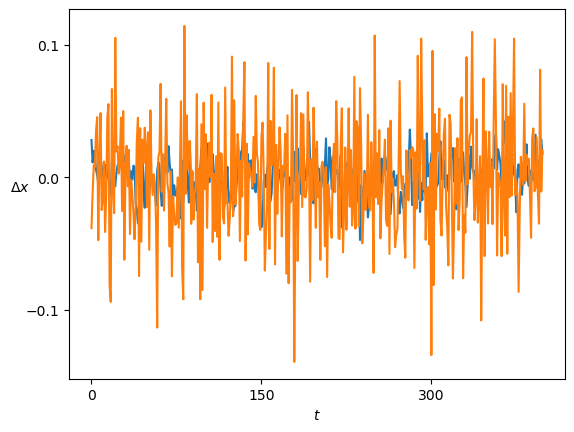

In [ ]:
plt.plot(ds_in.squeeze()[:2].T); plt.xlabel(r'$t$'); plt.ylabel(r'$\Delta x$', rotation=0);

FBM displacements follow a Gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ which is centered at $\mu=0$ and whose variance is related to the diffusion coefficient as $\sigma^2 = 2D$.

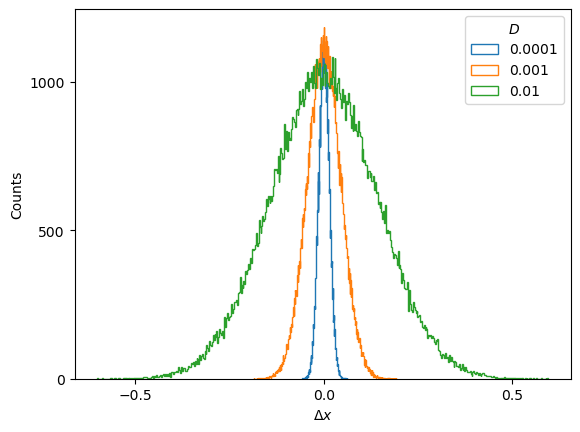

In [ ]:
for i,D in enumerate(u_D): plt.hist(ds_in[Ds_idx[i]].reshape(-1),500, histtype='step', label=f'{D:.2g}');
plt.ylabel('Counts'); plt.xlabel(r'$\Delta x$'); plt.legend(title=r'$D$');

In [ ]:
#|export
def plot_xf(x,f, ds_args, intersect_idx, x_label='', y_label='', title='',
            x_scale='linear',y_scale='linear',):
    """Plots `f(x)` using the provided indices"""
    for i,a in enumerate(ds_args["alpha"]):
        for j,D in enumerate(ds_args["D"]):
            plt.plot(f(x[intersect_idx[i,j]]), label=f'{a:.3g}, {D:.3g}');
    plt.xlabel(x_label);plt.ylabel(y_label, rotation=0);
    plt.xscale(x_scale);plt.yscale(y_scale);
    plt.title(title);

def f_a_text(a,y):    plt.text(0.95,y[-1],f'{a:.3g}', transform=matplotlib.transforms.blended_transform_factory(plt.gca().transAxes, plt.gca().transData));

def plot_xf_D(x,f, ds_args, intersect_idx, f_a=None,f_D=None,f_aD=None,each_D=True,each_g=True,  **kwargs):
    """Plots `f(x)` using the provided indices and auxiliary functions"""
    kwargs.update(dict(
        legend_title= r'$\alpha, D$',
        ncol=len(ds_args["alpha"])*len(ds_args["D"])//8 +1,
    ))
    for j,D in enumerate(ds_args["D"]):
        if each_D: plt.figure()
        for i,a in enumerate(ds_args["alpha"]):
            p = plt.plot(f(x[intersect_idx[i,j]]), label=f'{a:.2g}, {D:.2g}');
            if f_a: f_a(a,p[0]._y)
            if f_aD: f_aD(a,D)
        if f_D: f_D(D)
        if each_D: 
            if 'save' in kwargs: kwargs['save']=kwargs['save'][:kwargs['save'].rfind('_D')]+f'_D{D:.3g}'.replace('.','')
            set_plot_xf(**kwargs)
    if not each_D: set_plot_xf(**kwargs)

def set_plot_xf(x_label='', y_label='', title='',
                x_scale='linear',y_scale='linear',
                legend_title='', save=False,
                ncol=1, show_legend=True):
    plt.xlabel(x_label);plt.ylabel(y_label, rotation=0, ha='right');
    plt.xscale(x_scale);plt.yscale(y_scale);
    if ncol<4 and  show_legend==True: plt.legend(title=legend_title, bbox_to_anchor=(1,1), ncol=ncol);
    plt.title(title);plt.grid();
    if save:
        plt.savefig(save +'.png', bbox_inches='tight', pad_inches=0.1);
        print('Saved:' + save +'.png')
        plt.close();

Therefore, the mean and variance of the displacements constitute two straightforward sanity checks that the generated displacements must satisfy.

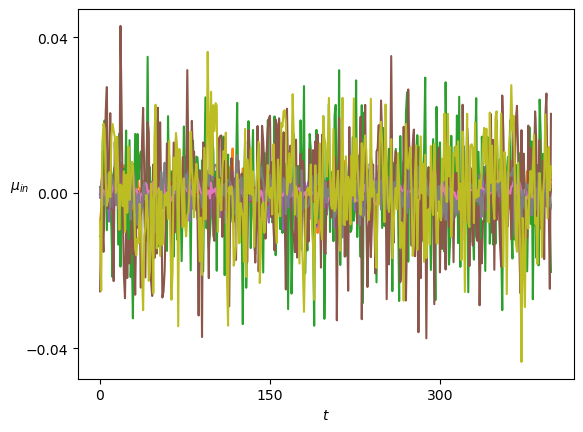

In [ ]:
plot_xf(ds_in, lambda x: x.squeeze().mean(0),ds_args, intersect_idx, x_label=r'$t$', y_label=r'$\mu_{in}$',)

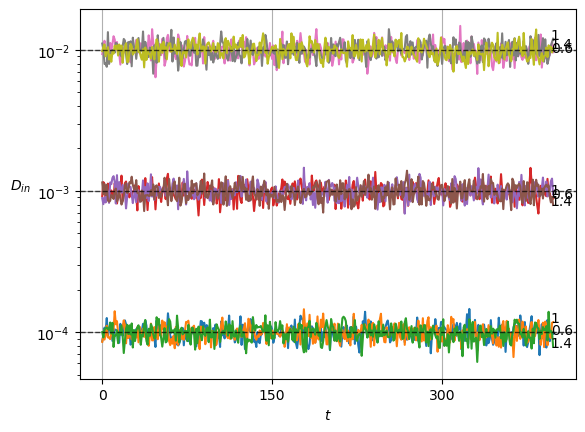

In [ ]:
plot_xf_D(ds_in, lambda x: sig2D(x.squeeze().std(0)),ds_args, intersect_idx,
          f_a=f_a_text,
          f_D=lambda D: plt.axhline(D, c='k', lw=1, ls='--', alpha=0.7),
          each_D=False,each_g=False, x_label=r'$t$', y_label=r'$D_{in}$',
          y_scale='log', show_legend=False,
         )

## SBM

Similarly, to load the dataset of SBM, we simply specify the dataset parameters in a dict and call `load_data` with it.

In [ ]:
Ds = [1e-5,1e-4,1e-3, 1e-2]  # np.geomspace(1e-5,1e-2, 10) 
alphas = np.linspace(0.2,1.8,21)
n_alphas, n_Ds = len(alphas), len(Ds)
ds_args = dict(path="../../data/raw/", model='sbm',
               N=int(100_000/n_alphas/n_Ds/2), T=400,
               D=Ds, alpha=alphas,
               N_save=1_000, T_save=400,
               seed=0, valid_pct=0.2, bs=2**8,)

In [ ]:
dls = load_data(ds_args)

As we did before, we can inspect the data that brings the `DataLoaders`.

In [ ]:
alphas_items = dls.valid.items[:,0]
Ds_items     = dls.valid.items[:,1]
ds_in_labels = dls.valid.items[:,:2] 
u_a=np.unique(alphas_items,)
u_D=np.unique(Ds_items,)
alphas_idx = [np.flatnonzero(alphas_items==a) for a in u_a]
Ds_idx = [np.flatnonzero(Ds_items==D) for D in u_D]
intersect_idx = np.array([[reduce(partial(np.intersect1d,assume_unique=True),
                                       (alphas_idx[i],Ds_idx[j]))
                                for j,D in enumerate(u_D)] for i,a in enumerate(u_a)], dtype=object)

In [ ]:
ds_in = []
with torch.no_grad():
    for b in tqdm(dls.valid):
        x,y=b
        ds_in.append(to_detach(x).numpy())
ds_in = np.concatenate(ds_in)
print(ds_in.shape)

  0%|          | 0/40 [00:00<?, ?it/s]

(9996, 1, 399)


SBM displacements have a zero mean but follow the scaling of the aging diffusion coefficient $D_\alpha (t) = \alpha D_0 t^{\alpha-1}$.

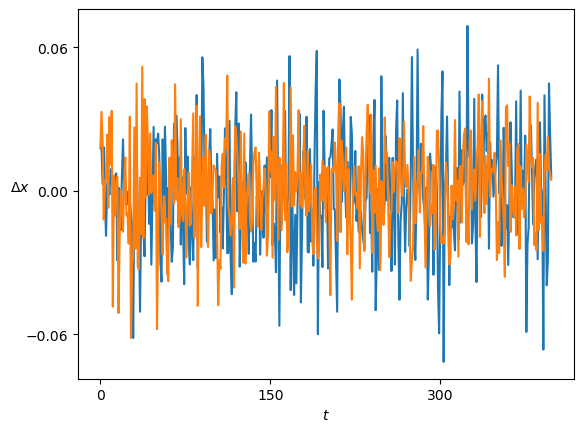

In [ ]:
plt.plot(ds_in.squeeze()[:2].T); plt.xlabel(r'$t$'); plt.ylabel(r'$\Delta x$', rotation=0);

For $\alpha<1$, the displacements become smaller as time passes.
On the contrary, $\alpha>1$ leads to a growth of the displacements.

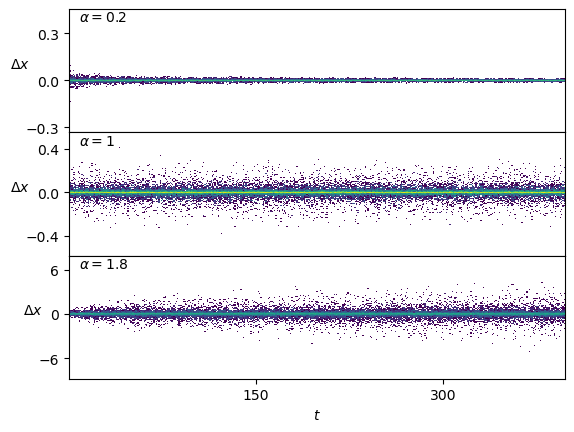

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
for ax, a_i in zip(axs,[0,10,20]):
    x = ds_in.squeeze()[alphas_idx[a_i]]
    ax.hist2d(np.tile(np.arange(x.shape[-1]),x.shape[0]),x.reshape(-1),x.shape[-1],
              cmin=2, norm=matplotlib.colors.LogNorm());
    ax.text(0.02,0.9, r'$\alpha=' f'{u_a[a_i]:.3g}' r'$', transform=ax.transAxes);
    ax.set_ylabel(r'$\Delta x$', rotation=0);
axs[-1].set_xlabel(r'$t$');

We plot the means of the displacements.

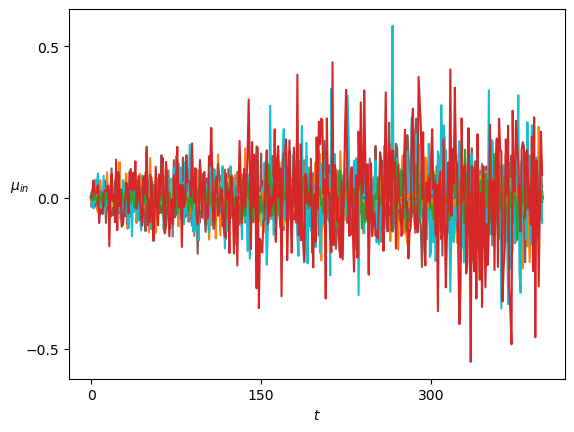

In [ ]:
plot_xf(ds_in, lambda x: x.squeeze().mean(0),ds_args, intersect_idx, x_label=r'$t$', y_label=r'$\mu_{in}$',)

In SBM, each $\alpha$ is shown in the variance at each time step.
Thus, this simple sanity check is now a direct observation of the displacements properties.

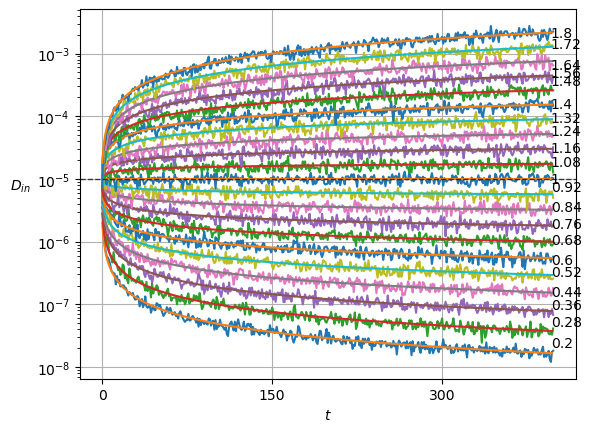

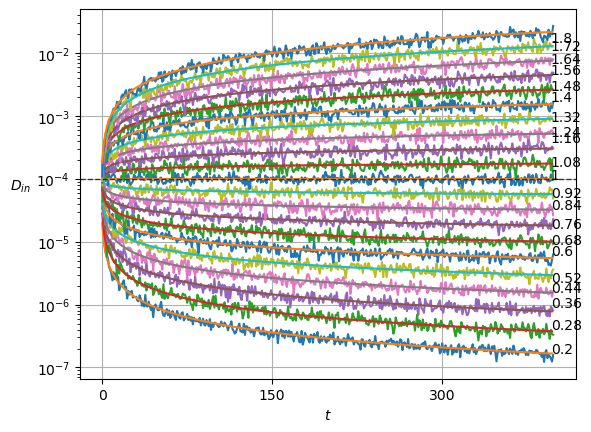

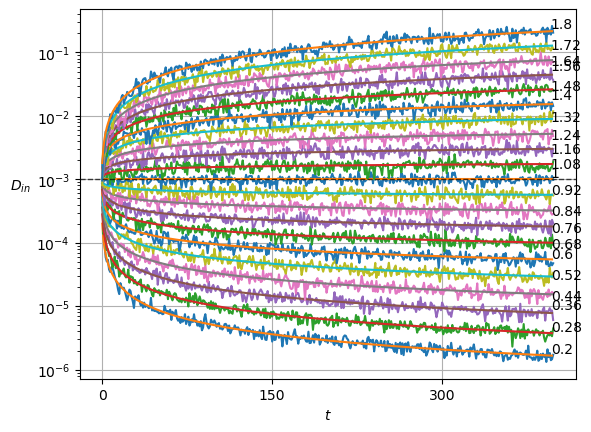

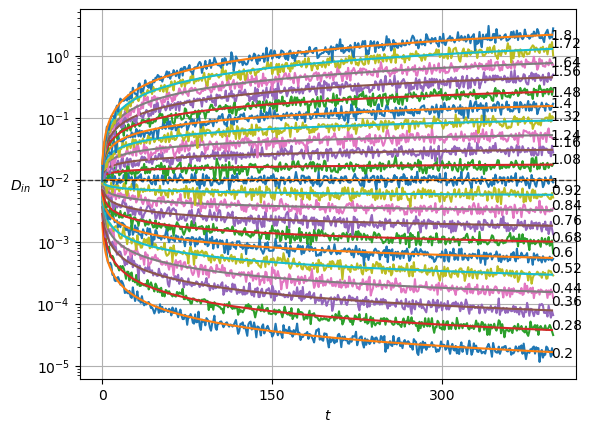

In [ ]:
x = ds_in.squeeze()
plot_xf_D(x, lambda x: sig2D(x.squeeze().std(0)),ds_args, intersect_idx,
          f_a=lambda a,y: plt.text(0.95,y[-10],f'{a:.3g}', transform=matplotlib.transforms.blended_transform_factory(plt.gca().transAxes, plt.gca().transData)),
          f_D=lambda D: plt.axhline(D, c='k', lw=1, ls='--', alpha=0.7),
          f_aD=lambda a,D: plt.plot(a*D*np.arange(1,x.shape[-1])**(a-1.)),
          each_D=True,each_g=False, x_label=r'$t$', y_label=r'$D_{in}$',
          y_scale='log', show_legend=False,
         )